In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
from lib.sampling import get_slides
size=256
path = Path('./')

database = Database()
database.open(str(path/'databases/MITOS_WSI_CCMCT_ODAEL.sqlite'))

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [2]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, database=database,basepath='WSI')

Loading slides .. : 100%|██████████| 32/32 [00:12<00:00,  3.24it/s]


In [3]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [4]:
bs = 16
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [5]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [6]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

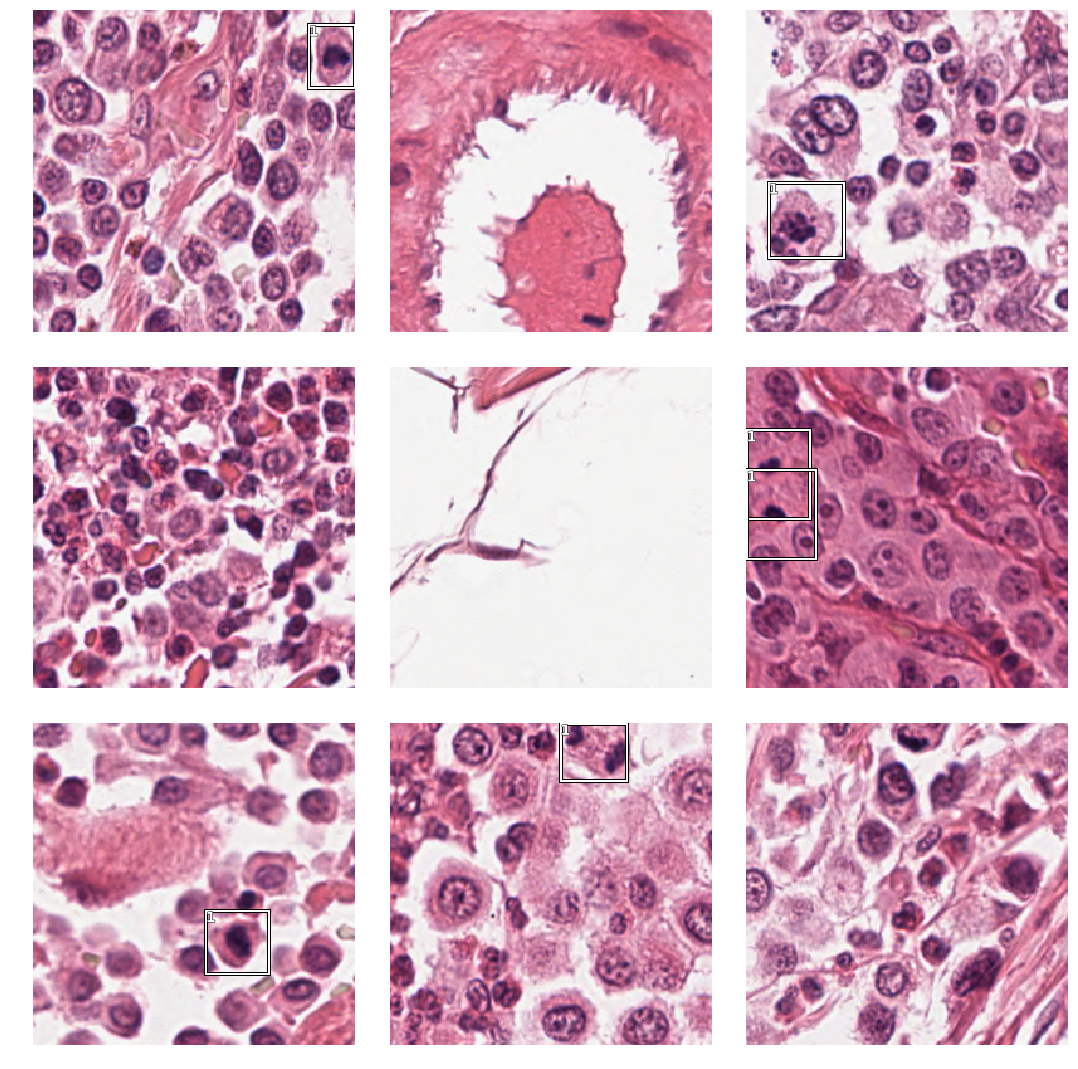

In [7]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [10]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])


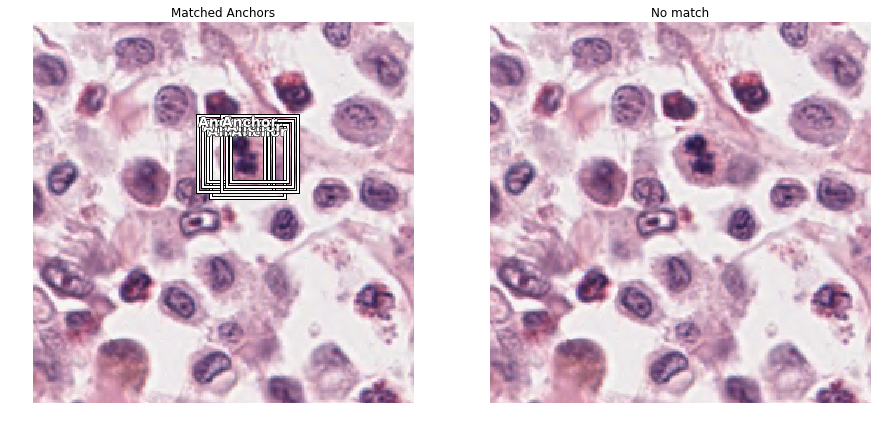

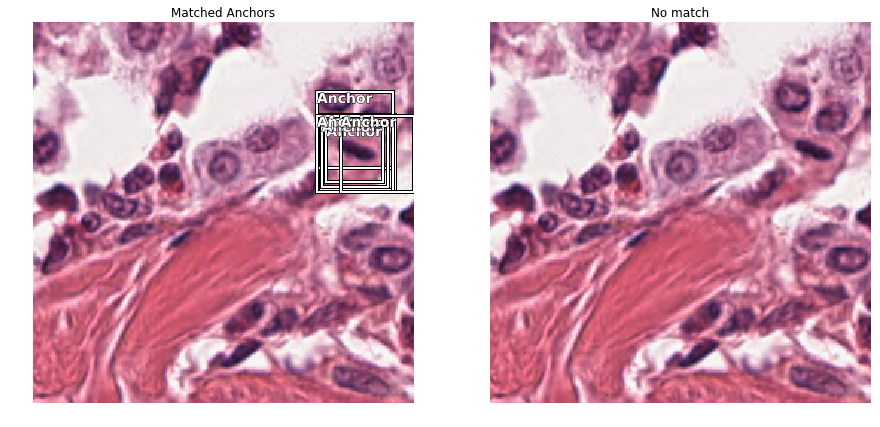

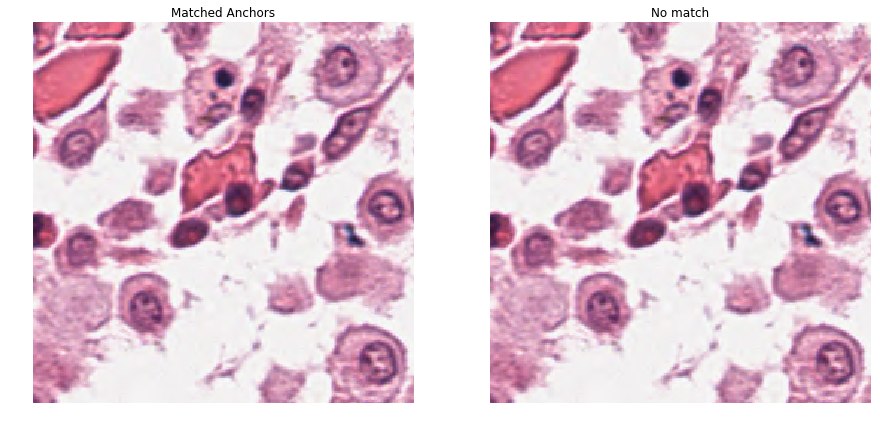

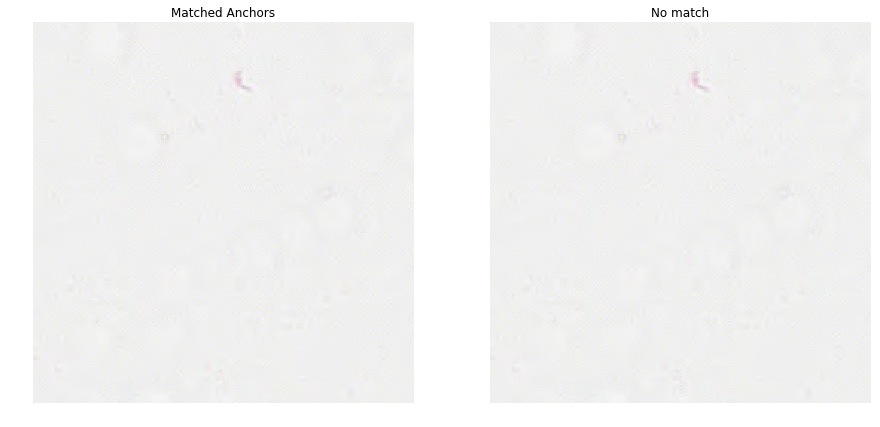

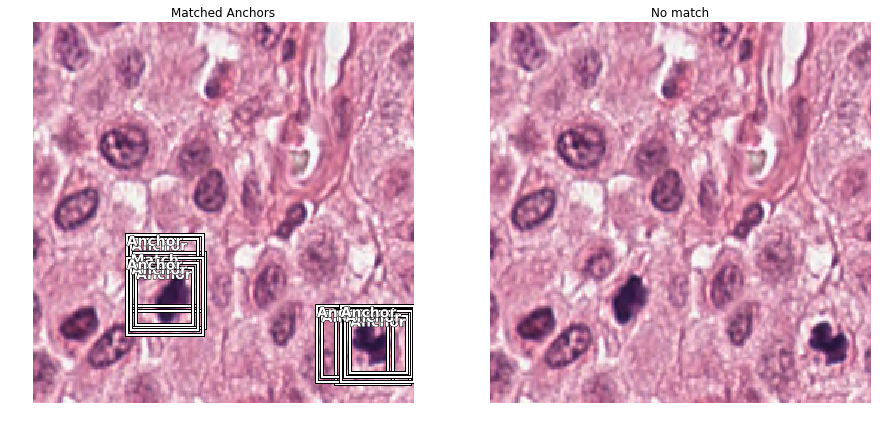

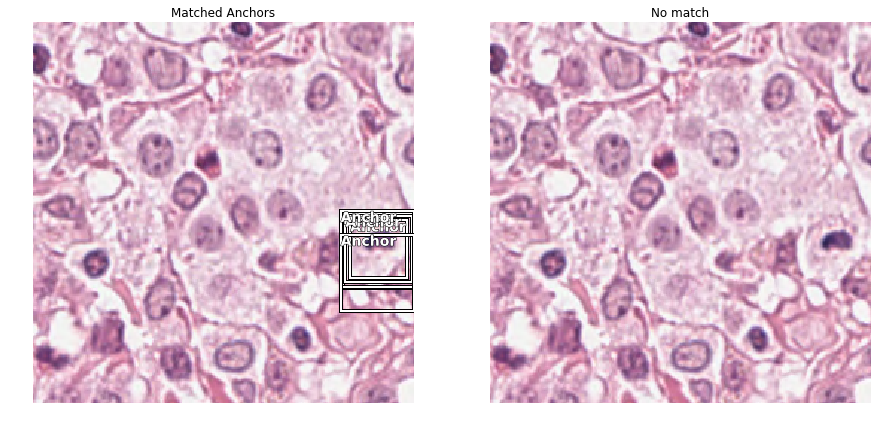

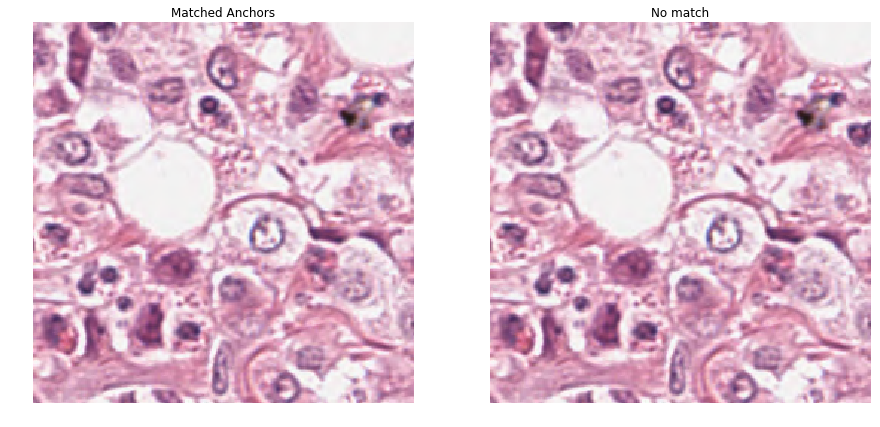

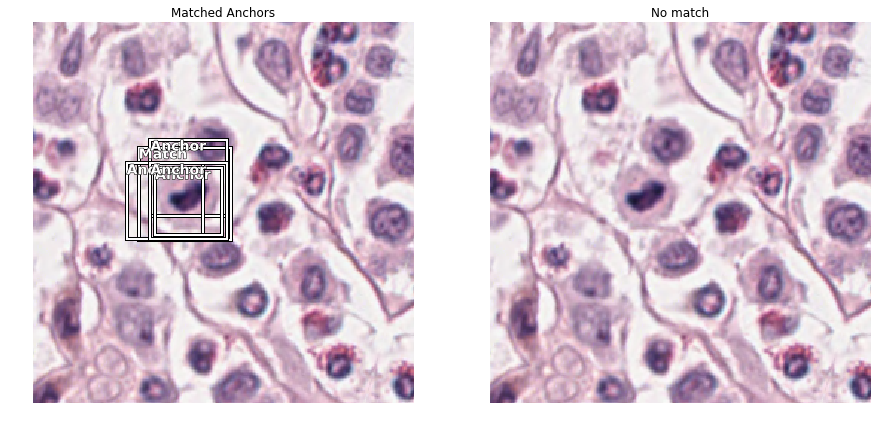

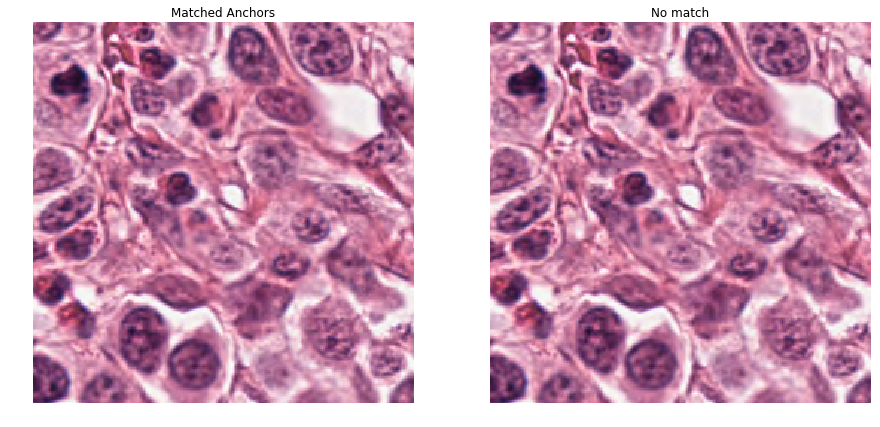

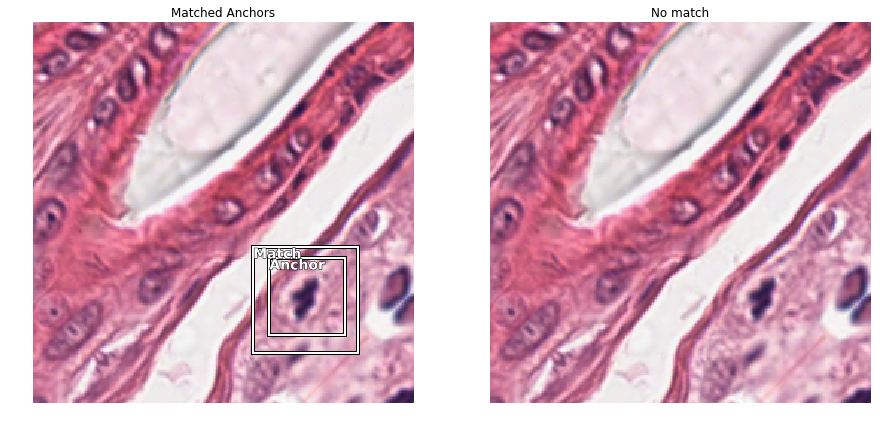

In [11]:
not_found = show_anchors_on_images(data, anchors)

In [12]:
crit = RetinaNetFocalLoss(anchors)

In [13]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [14]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [15]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


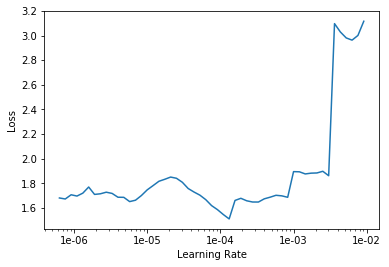

In [16]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1826/1826 [00:00<00:00, 2399.25it/s]


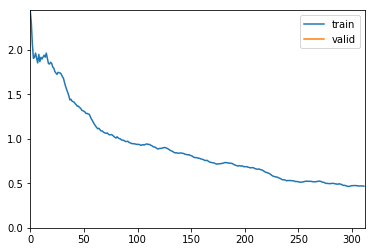

In [17]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 1917/1917 [00:00<00:00, 2946.81it/s]


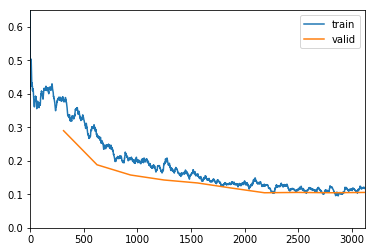

GT: 100%|██████████| 2040/2040 [00:00<00:00, 2216.33it/s]


In [18]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 2005/2005 [00:00<00:00, 2322.40it/s]


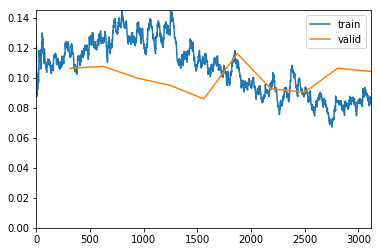

GT: 100%|██████████| 1921/1921 [00:00<00:00, 3348.00it/s]


GT: 100%|██████████| 2000/2000 [00:00<00:00, 2706.92it/s]


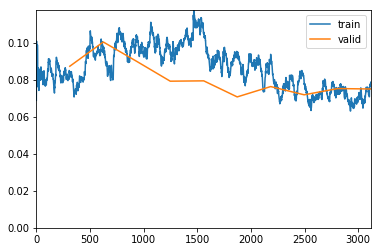

GT: 100%|██████████| 2038/2038 [00:00<00:00, 2514.96it/s]


GT: 100%|██████████| 1999/1999 [00:00<00:00, 2235.39it/s]


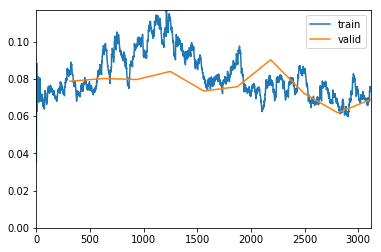

GT: 100%|██████████| 1993/1993 [00:00<00:00, 2144.05it/s]


In [19]:
learn.unfreeze()
lr=1e-4

for k in range(3):
    learn.fit_one_cycle(10, lr)

GT: 100%|██████████| 2004/2004 [00:00<00:00, 2161.17it/s]


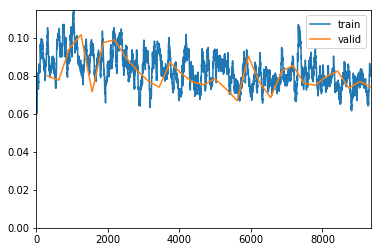

Better model found at epoch 0 with AP-0 value: 0.7549253460386938.


GT: 100%|██████████| 2005/2005 [00:00<00:00, 2072.24it/s]


Better model found at epoch 1 with AP-0 value: 0.8415458313133541.


GT: 100%|██████████| 2016/2016 [00:00<00:00, 2640.51it/s]


Better model found at epoch 2 with AP-0 value: 0.8647581522713572.


GT: 100%|██████████| 2004/2004 [00:00<00:00, 2083.16it/s]


Better model found at epoch 16 with AP-0 value: 0.875676365122779.


GT: 100%|██████████| 1960/1960 [00:00<00:00, 2338.27it/s]


Better model found at epoch 18 with AP-0 value: 0.9006403171868694.


GT: 100%|██████████| 1978/1978 [00:00<00:00, 2632.40it/s]


Better model found at epoch 25 with AP-0 value: 0.9129867403436377.


GT: 100%|██████████| 2032/2032 [00:00<00:00, 2324.64it/s]


In [20]:
learn.unfreeze()
lr=1e-4

learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 2006/2006 [00:00<00:00, 2547.48it/s]


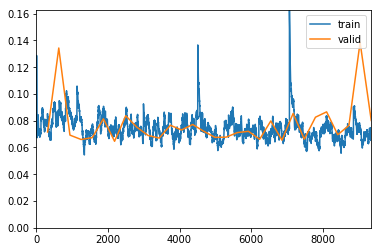

Better model found at epoch 0 with AP-0 value: 0.8641377525494449.


GT: 100%|██████████| 1939/1939 [00:00<00:00, 2595.20it/s]


Better model found at epoch 1 with AP-0 value: 0.8735934816021669.


GT: 100%|██████████| 2030/2030 [00:00<00:00, 2436.73it/s]


Better model found at epoch 7 with AP-0 value: 0.8906366656615601.


GT: 100%|██████████| 1986/1986 [00:00<00:00, 2212.41it/s]


In [21]:
learn.save('RetinaNet-ODAEL-save-2.pth', with_opt=True)
learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

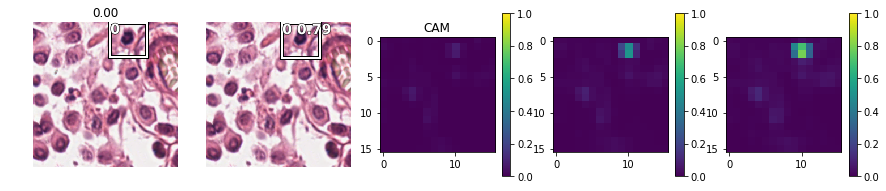

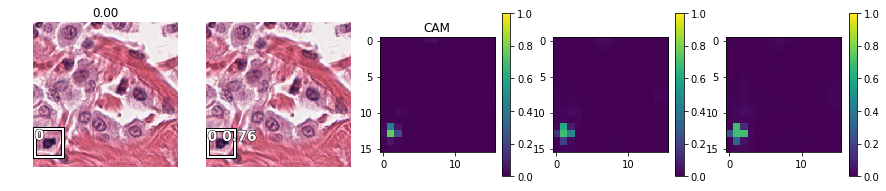

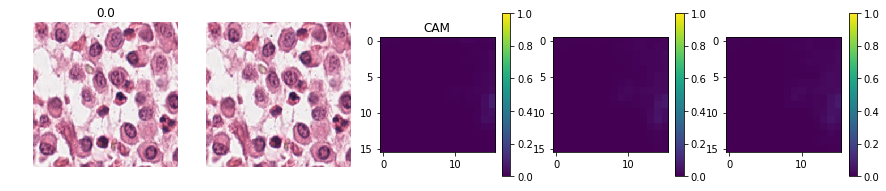

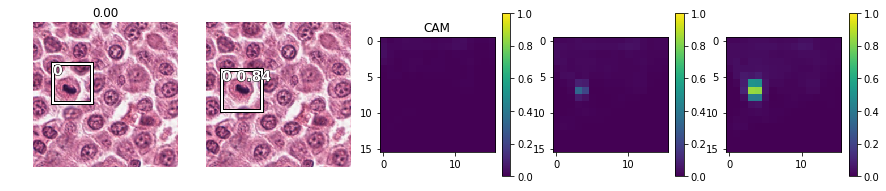

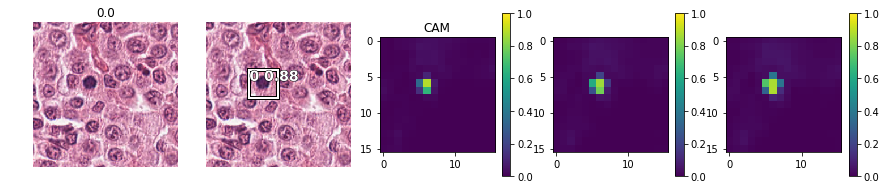

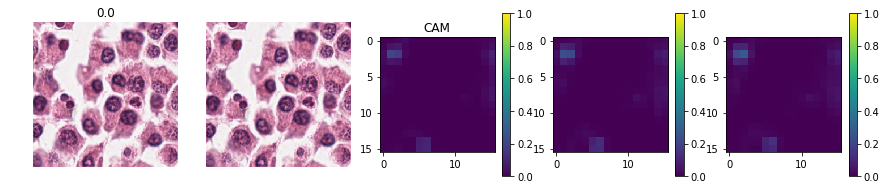

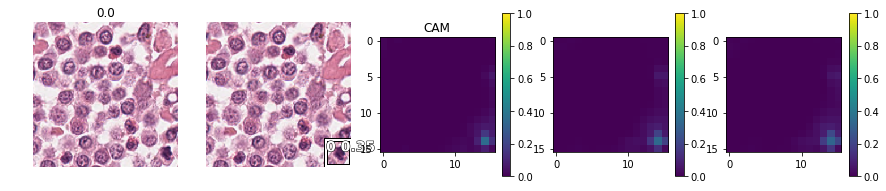

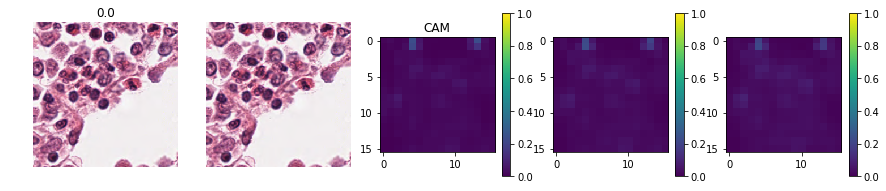

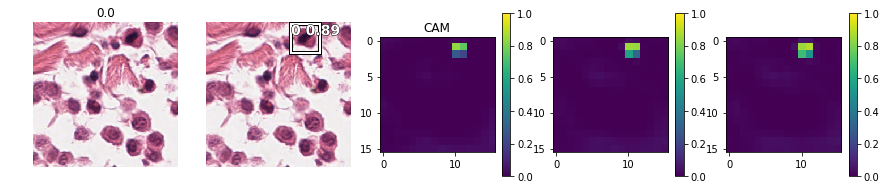

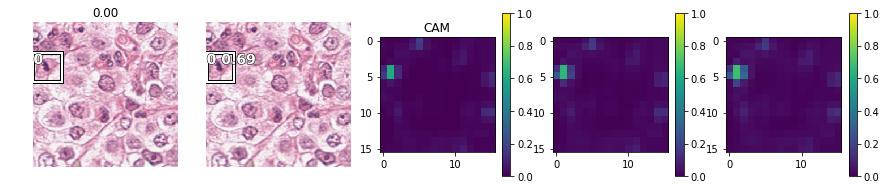

In [22]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [23]:
learn.save('RetinaNe-ODAEL-save.pth', with_opt=True)
learn.export("../RetinaNet-ODAEL-export.pth")